In [1]:
!nvidia-smi

Thu Oct  9 19:33:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
! pip install -q transformers[sentencepiece] fastbook fastai nbdev plum-dispatch evaluate seqeval

In [3]:
!git clone https://github.com/msi1427/blurr.git
%cd blurr

fatal: destination path 'blurr' already exists and is not an empty directory.
/content/blurr


In [4]:
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import pandas as pd
import torch
import json
import ast
import re
from transformers import AutoModelForSequenceClassification, AutoConfig

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%cd /content/drive/MyDrive/MasterCourse/Multi-Label Text Classification of Scientific Articles in Computer Science/arXiv-Subjects-dataset

/content/drive/MyDrive/MasterCourse/Multi-Label Text Classification of Scientific Articles in Computer Science/arXiv-Subjects-dataset


In [9]:
df = pd.read_csv("arxiv_cs_papers_combined.csv")
print(f"Original shape: {df.shape}")
display(df.head(5))

Original shape: (30000, 5)


,title,abstract,subjects,url,authors
0,NFTrig,"NFTrig is a web-based application created for use as an educational tool to teach trigonometry and block chain technology. Creation of the application includes front and back end development as well as integration with other outside sources including MetaMask and OpenSea. The primary development languages include HTML, CSS (Bootstrap 5), and JavaScript as well as Solidity for smart contract creation. The application itself is hosted on Moralis utilizing their Web3 API. This technical report describes how the application was created, what the application requires, and smart contract design ...",['Human-Computer Interaction (cs.HC)'],https://arxiv.org/abs/2301.00001,"['Jordan Thompson', 'Ryan Benac', 'Kidus Olana', 'Talha Hassan', 'Andrew Sward', 'Tauheed Khan Mohd']"
1,Evaluating Alternative Glyph Design for Showing Large-Magnitude-Range Quantum Spins,"We present experimental results to explore a form of bivariate glyphs for representing large-magnitude-range vectors. The glyphs meet two conditions: (1) two visual dimensions are separable; and (2) one of the two visual dimensions uses a categorical representation (e.g., a categorical colormap). We evaluate how much these two conditions determine the bivariate glyphs' effectiveness. The first experiment asks participants to perform three local tasks requiring reading no more than two glyphs. The second experiment scales up the search space in global tasks when participants must look at th...","['Human-Computer Interaction (cs.HC)', 'Graphics (cs.GR)', 'Quantum Physics (quant-ph)']",https://arxiv.org/abs/2301.00002,"['Henan Zhao', 'Garnett W. Bryant', 'Wesley Griffin', 'Judith E. Terrill', 'Jian Chen']"
2,Emotion in Cognitive Architecture: Emergent Properties from Interactions with Human Emotion,"This document presents endeavors to represent emotion in a computational cognitive architecture. The first part introduces research organizing with two axes of emotional affect: pleasantness and arousal. Following this basic of emotional components, the document discusses an aspect of emergent properties of emotion, showing interaction studies with human users. With these past author's studies, the document concludes that the advantage of the cognitive human-agent interaction approach is in representing human internal states and processes.","['Human-Computer Interaction (cs.HC)', 'Artificial Intelligence (cs.AI)']",https://arxiv.org/abs/2301.00003,['Junya Morita']
3,Intrinsic Motivation in Dynamical Control Systems,"Biological systems often choose actions without an explicit reward signal, a phenomenon known as intrinsic motivation. The computational principles underlying this behavior remain poorly understood. In this study, we investigate an information-theoretic approach to intrinsic motivation, based on maximizing an agent's empowerment (the mutual information between its past actions and future states). We show that this approach generalizes previous attempts to formalize intrinsic motivation, and we provide a computationally efficient algorithm for computing the necessary quantities. We test our...","['Artificial Intelligence (cs.AI)', 'Applied Physics (physics.app-ph)']",https://arxiv.org/abs/2301.00005,"['Stas Tiomkin', 'Ilya Nemenman', 'Daniel Polani', 'Naftali Tishby']"
4,Recovering Top-Two Answers and Confusion Probability in Multi-Choice Crowdsourcing,"Crowdsourcing has emerged as an effective platform for labeling large amounts of data in a cost- and time-efficient manner. Most previous work has focused on designing an efficient algorithm to recover only the ground-truth labels of the data. In this paper, we consider multi-choice crowdsourcing tasks with the goal of recovering not only the ground truth, but also the most confusing answer and the confusion probability. The most confusing answer provides useful information about the task by revealing the most plausible answer other than the ground truth and how plausible it is. To

In [10]:
def clean_abstract(text):
    """Clean abstract text (remove LaTeX, URLs, punctuation, lowercase)."""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = text.encode('utf-8', errors='ignore').decode('utf-8').lower()
    text = re.sub(r'http[s]?://\S+|this https URL', '', text)
    text = re.sub(r'\\text(sub|super)script\{([^}]*)\}', r'\2', text)
    text = re.sub(r'\$[^\$]*\$', '', text)
    text = re.sub(r'\\[a-zA-Z]+', '', text)
    text = re.sub(r'[^\w\s-]', '', text)
    return text.strip()

df['abstract'] = df['abstract'].apply(clean_abstract)
df = df[df['abstract'].str.len() > 0].reset_index(drop=True)
print(f"\n Cleaned abstracts: {df.shape}")
print("Sample cleaned abstract:", df['abstract'].iloc[0][:200] + "...")


 Cleaned abstracts: (30000, 5)
Sample cleaned abstract: nftrig is a web-based application created for use as an educational tool to teach trigonometry and block chain technology creation of the application includes front and back end development as well as...


In [11]:

def clean_subjects(subjects_str):
    """Parse subjects into list of full names, removing invalid entries."""
    if pd.isna(subjects_str) or not isinstance(subjects_str, str):
        return []
    try:
        subjects_list = ast.literal_eval(subjects_str)
        if not isinstance(subjects_list, list):
            subjects_list = [subjects_list]
        return [s for s in subjects_list if isinstance(s, str) and s.strip()]
    except:
        return []

df['revised_subjects'] = df['subjects'].apply(clean_subjects)
df = df[df['revised_subjects'].str.len() > 0].reset_index(drop=True)
print(f"\n Cleaned subjects: {df.shape}")
print("Sample cleaned subjects:", df['revised_subjects'].iloc[0])


 Cleaned subjects: (30000, 6)
Sample cleaned subjects: ['Human-Computer Interaction (cs.HC)']


In [12]:
subjects_list = df.revised_subjects.to_list()
subject_count = {}
for subjects in subjects_list:
    subject_list = subjects
    for subject in subject_list:
        if subject in subject_count.keys():
            subject_count[subject] += 1
        else:
            subject_count[subject] = 1
print(f"Number of Subjects: {len(subject_count)}")
print("Sample subject counts:", dict(list(subject_count.items())[:]))

Number of Subjects: 141
Sample subject counts: {'Human-Computer Interaction (cs.HC)': 1389, 'Graphics (cs.GR)': 340, 'Quantum Physics (quant-ph)': 98, 'Artificial Intelligence (cs.AI)': 7613, 'Applied Physics (physics.app-ph)': 40, 'Information Theory (cs.IT)': 1209, 'Machine Learning (cs.LG)': 10053, 'Machine Learning (stat.ML)': 960, 'Neural and Evolutionary Computing (cs.NE)': 550, 'Computer Vision and Pattern Recognition (cs.CV)': 6419, 'Other Computer Science (cs.OH)': 26, 'Optimization and Control (math.OC)': 499, 'Statistics Theory (math.ST)': 104, 'Cryptography and Security (cs.CR)': 1797, 'Information Retrieval (cs.IR)': 934, 'Computers and Society (cs.CY)': 1178, 'Networking and Internet Architecture (cs.NI)': 806, 'Formal Languages and Automata Theory (cs.FL)': 139, 'Robotics (cs.RO)': 1921, 'Software Engineering (cs.SE)': 1144, 'Computation and Language (cs.CL)': 4388, 'Audio and Speech Processing (eess.AS)': 574, 'Numerical Analysis (math.NA)': 1313, 'Computational Physics

In [13]:
threshold = int(len(df) * 0.005)
rare_subjects = [key for key, value in subject_count.items() if value < threshold]
print(f"Number of rare subjects: {len(rare_subjects)}, Sample: {rare_subjects[:]}")

revised_subjects_list = []
indices_to_drop = []
for idx, subjects in enumerate(subjects_list):
    revised_subjects = [s for s in subjects if s not in rare_subjects]
    if len(revised_subjects) == 0:
        indices_to_drop.append(idx)
    else:
        revised_subjects_list.append(revised_subjects)

df = df.drop(indices_to_drop).reset_index(drop=True)
df['revised_subjects'] = revised_subjects_list
print(f"\n After filtering rare subjects: {df.shape}")


Number of rare subjects: 103, Sample: ['Quantum Physics (quant-ph)', 'Applied Physics (physics.app-ph)', 'Other Computer Science (cs.OH)', 'Statistics Theory (math.ST)', 'Formal Languages and Automata Theory (cs.FL)', 'Computational Physics (physics.comp-ph)', 'Operating Systems (cs.OS)', 'Symbolic Computation (cs.SC)', 'Adaptation and Self-Organizing Systems (nlin.AO)', 'Physics and Society (physics.soc-ph)', 'Mathematical Physics (math-ph)', 'Commutative Algebra (math.AC)', 'Methodology (stat.ME)', 'Computation (stat.CO)', 'Applications (stat.AP)', 'Performance (cs.PF)', 'Biomolecules (q-bio.BM)', 'Genomics (q-bio.GN)', 'Classical Analysis and ODEs (math.CA)', 'Rings and Algebras (math.RA)', 'Neurons and Cognition (q-bio.NC)', 'Dynamical Systems (math.DS)', 'Molecular Networks (q-bio.MN)', 'Fluid Dynamics (physics.flu-dyn)', 'Econometrics (econ.EM)', 'Probability (math.PR)', 'Mathematical Software (cs.MS)', 'Soft Condensed Matter (cond-mat.soft)', 'Number Theory (math.NT)', 'Computat

In [14]:
revised_subject_count = {}
for subjects in revised_subjects_list:
    for subject in subjects:
        if subject in revised_subject_count:
            revised_subject_count[subject] += 1
        else:
            revised_subject_count[subject] = 1
print(f"Number of Revised Subjects: {len(revised_subject_count)}")
print("Sample revised subject counts:", dict(list(revised_subject_count.items())[:]))

Number of Revised Subjects: 38
Sample revised subject counts: {'Human-Computer Interaction (cs.HC)': 1389, 'Graphics (cs.GR)': 340, 'Artificial Intelligence (cs.AI)': 7613, 'Information Theory (cs.IT)': 1209, 'Machine Learning (cs.LG)': 10053, 'Machine Learning (stat.ML)': 960, 'Neural and Evolutionary Computing (cs.NE)': 550, 'Computer Vision and Pattern Recognition (cs.CV)': 6419, 'Optimization and Control (math.OC)': 499, 'Cryptography and Security (cs.CR)': 1797, 'Information Retrieval (cs.IR)': 934, 'Computers and Society (cs.CY)': 1178, 'Networking and Internet Architecture (cs.NI)': 806, 'Robotics (cs.RO)': 1921, 'Software Engineering (cs.SE)': 1144, 'Computation and Language (cs.CL)': 4388, 'Audio and Speech Processing (eess.AS)': 574, 'Numerical Analysis (math.NA)': 1313, 'Computational Complexity (cs.CC)': 220, 'Data Structures and Algorithms (cs.DS)': 553, 'Systems and Control (eess.SY)': 1549, 'Social and Information Networks (cs.SI)': 629, 'Sound (cs.SD)': 557, 'Hardware A

In [15]:
encode_subject_types = {key: idx for idx, (key, value) in enumerate(revised_subject_count.items())}
with open("subject_types_encoded.json", "w") as fp:
    json.dump(encode_subject_types, fp, indent=4)
labels = list(encode_subject_types.keys())
print(f"\n Saved subject_types_encoded.json with {len(labels)} subjects")
print(f"Sample labels: {labels[:5]}")


 Saved subject_types_encoded.json with 38 subjects
Sample labels: ['Human-Computer Interaction (cs.HC)', 'Graphics (cs.GR)', 'Artificial Intelligence (cs.AI)', 'Information Theory (cs.IT)', 'Machine Learning (cs.LG)']


In [16]:
categorical_subject_list = []
for subjects in revised_subjects_list:
    categorical_list = [0] * len(labels)
    for subject in subjects:
        if subject in encode_subject_types:
            subject_idx = encode_subject_types[subject]
            categorical_list[subject_idx] = 1
    categorical_subject_list.append(categorical_list)
df['subject_cat_list'] = categorical_subject_list
print(f"Sample binary label vector: {categorical_subject_list[0][:10]}")
print(df.head())

Sample binary label vector: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                                                                                         title  \
0                                                                                       NFTrig   
1          Evaluating Alternative Glyph Design for Showing Large-Magnitude-Range Quantum Spins   
2  Emotion in Cognitive Architecture: Emergent Properties from Interactions with Human Emotion   
3                                            Intrinsic Motivation in Dynamical Control Systems   
4           Recovering Top-Two Answers and Confusion Probability in Multi-Choice Crowdsourcing   

                                                                                                                                                                                                                                                                                                                                                                

In [17]:
model_name = "distilbert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [18]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=512),
    MultiCategoryBlock(encoded=True, vocab=labels)
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader('abstract'),
    get_y=ColReader('subject_cat_list'),
    splitter=RandomSplitter(valid_pct=0.1, seed=42)
)
try:
    dls = dblock.dataloaders(df, bs=32)
except Exception as e:
    raise Exception(f"Failed to create DataLoaders: {str(e)}")
model_name_safe = model_name.replace('/', '_')
os.makedirs(f"{model_name_safe}_dataloaders", exist_ok=True)
torch.save(dls, f"{model_name_safe}_dataloaders/dls-multilabel-arxiv-classifier.pkl")
print(f"\n Saved classification DataLoaders to {model_name_safe}_dataloaders/dls-multilabel-arxiv-classifier.pkl")


 Saved classification DataLoaders to distilbert-base-uncased_dataloaders/dls-multilabel-arxiv-classifier.pkl


In [19]:
model = BaseModelWrapper(hf_model)
acc_05 = partial(accuracy_multi, thresh=0.5)
learner = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[acc_05, F1ScoreMulti()],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter
).to_fp16()

Suggested LR → Slide: 2.75e-02, Valley: 5.75e-04


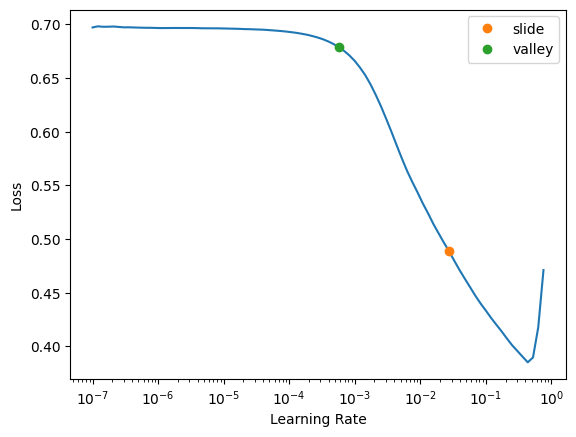

In [20]:
# Training Stage 0 - Frozen
learner.freeze()
lr_min, lr_steep = learner.lr_find(suggest_funcs=(slide, valley))
print(f"Suggested LR → Slide: {lr_min:.2e}, Valley: {lr_steep:.2e}")

In [21]:
learner.fit_one_cycle(2, 3.31e-04)
os.makedirs("models", exist_ok=True)
learner.save(f"{model_name_safe}_arxiv-classifier-stage-0")
learner.export(f"models/{model_name_safe}_arxiv-classifier-stage-0.pkl")
print(f"Stage 0 saved to models/{model_name_safe}_arxiv-classifier-stage-0.pkl")

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.114502,0.109709,0.961092,0.074955,01:45
1,0.100686,0.099750,0.963283,0.128708,01:45


Stage 0 saved to models/distilbert-base-uncased_arxiv-classifier-stage-0.pkl


Suggested LR → Slide: 1.91e-02, Valley: 1.91e-04


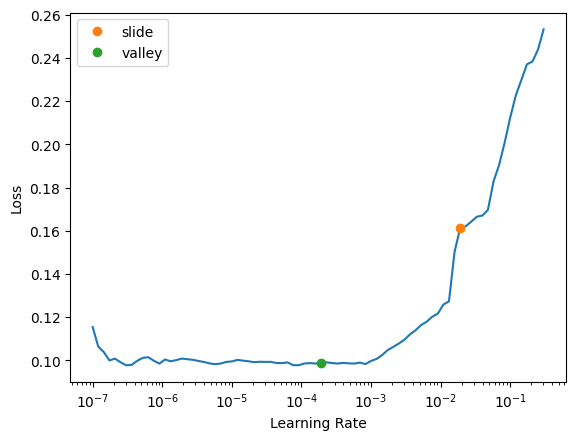

In [22]:
learner.unfreeze()
lr_min, lr_steep = learner.lr_find(suggest_funcs=(slide, valley))
print(f"Suggested LR → Slide: {lr_min:.2e}, Valley: {lr_steep:.2e}")


In [23]:
learner.fit_one_cycle(5, slice(1.58e-05, 1.58e-04))
learner.save(f"{model_name_safe}_arxiv-classifier-stage-1")
learner.export(f"models/{model_name_safe}_arxiv-classifier-stage-1.pkl")
print(f"Stage 1 saved to models/{model_name_safe}_arxiv-classifier-stage-1.pkl")

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.081145,0.079939,0.969628,0.341085,02:29
1,0.071630,0.073361,0.971882,0.448944,02:28
2,0.062294,0.070385,0.972880,0.528366,02:29
3,0.055140,0.070315,0.973074,0.548351,02:29
4,0.048159,0.071241,0.972933,0.547515,02:29


Stage 1 saved to models/distilbert-base-uncased_arxiv-classifier-stage-1.pkl


In [24]:
val_metrics = learner.validate()
print(f"Validation Loss: {val_metrics[0]:.4f}")
print(f"Multi-Label Accuracy: {val_metrics[1]:.4f}")
print(f"Multi-Label F1 Score: {val_metrics[2]:.4f}")


Validation Loss: 0.0712
Multi-Label Accuracy: 0.9729
Multi-Label F1 Score: 0.5475


In [25]:
from sklearn.metrics import classification_report
val_preds, val_targs, val_losses = learner.get_preds(ds_idx=1, with_loss=True)
val_preds = (val_preds >= 0.5).int().numpy()
val_targs = val_targs.numpy()
print("\nClassification Report:")
print(classification_report(val_targs, val_preds, target_names=labels))


Classification Report:
                                                         precision    recall  f1-score   support

                     Human-Computer Interaction (cs.HC)       0.69      0.52      0.59       135
                                       Graphics (cs.GR)       0.52      0.46      0.49        26
                        Artificial Intelligence (cs.AI)       0.55      0.35      0.42       787
                             Information Theory (cs.IT)       0.83      0.74      0.78       109
                               Machine Learning (cs.LG)       0.79      0.67      0.73      1036
                             Machine Learning (stat.ML)       0.30      0.14      0.19        94
              Neural and Evolutionary Computing (cs.NE)       0.72      0.52      0.60        66
        Computer Vision and Pattern Recognition (cs.CV)       0.88      0.90      0.89       631
                     Optimization and Control (math.OC)       0.50      0.10      0.16        31
     

In [26]:
learner.save(f"{model_name_safe}_arxiv-classifier-final")
learner.export(f"models/{model_name_safe}_arxiv_multilabel_classifier.pkl")
print(f"Final model exported as models/{model_name_safe}_arxiv_multilabel_classifier.pkl")

Final model exported as models/distilbert-base-uncased_arxiv_multilabel_classifier.pkl
